# 160. mnist dataset 손글씨 인식 - Multi-class Classification

- Basic Fully Connected Layer 이용

- nn.CrossEntropyLoss 이용

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset handling
- ``transforms.ToTensor()`` - image 를 tensor로 변환 + [0.0,1.0] 범위로 scaling  
- ```SubsetSampler``` - 주어진 인덱스 목록에서 무작위로 비복원 추출

In [3]:
# download mnist data
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root='./data', train=False, 
                           download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 168015256.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95911079.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34306208.04it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19419499.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)
print(train_data[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([1, 28, 28])
5


In [5]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

- Data 시각화

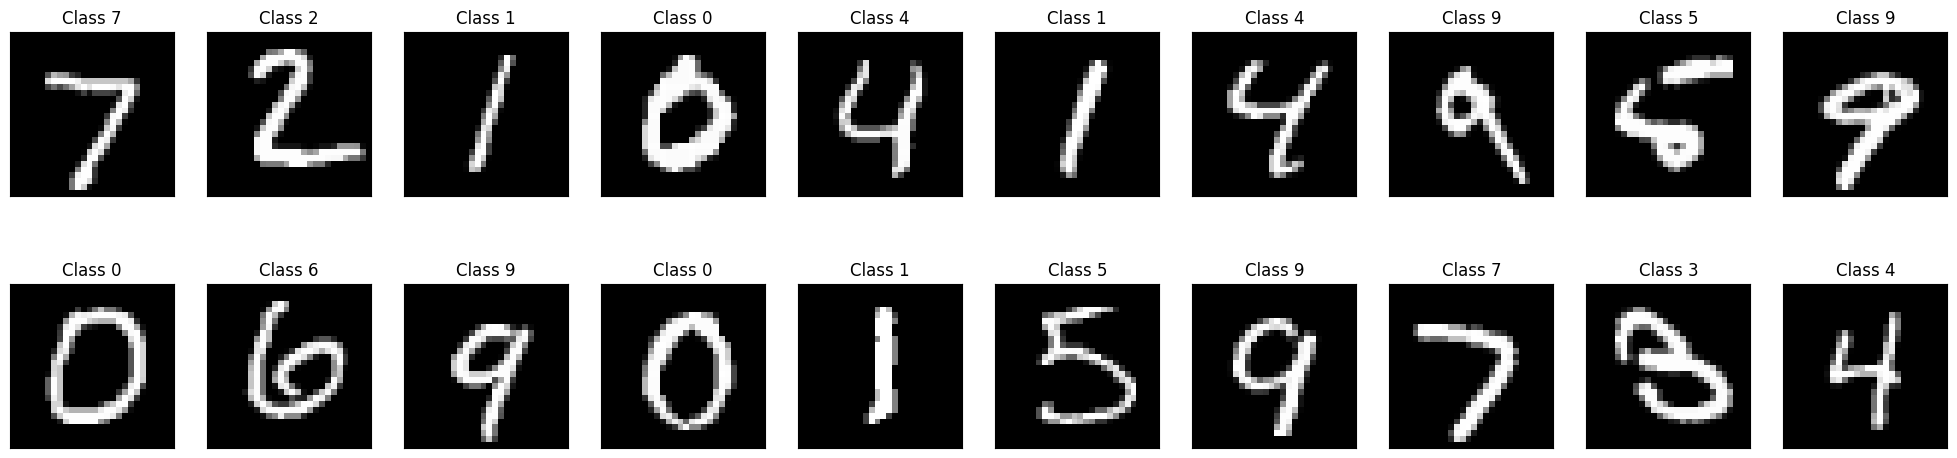

In [6]:
plt.figure(figsize=(25, 6))

for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.view(28, 28), cmap='gray')  
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

## Dataset Loader 생성

- Train dataset 을 Train 과 Validation set 으로 분리

In [7]:
valid_size = 0.2  # validation set 으로 사용할 train_dataset size

num_train = len(train_data)
indices = list(range(num_train))

np.random.shuffle(indices)   # shuffle data
split = int(np.floor(valid_size * num_train))  #split data size
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx), len(valid_idx))

# sampler 정의
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

48000 12000


- train, validation, test dataset 으로 3 분할

In [8]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                batch_size=batch_size, sampler=valid_sampler)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, 
                                batch_size=batch_size, shuffle=False)

### Model custom build

- nn.Linear 이용
- activation 으로 relu 함수 적용
- 2개의 hidden layer와 dropout 사용

<img src="linear.png" width="600" />

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
model = Net().to(device)

### Model Summary

In [11]:
model

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

- model 의 parameter 갯수 

In [12]:
for k, v in model.state_dict().items():
    print(k, v.numel())
    
print("total trainable params", sum(p.numel() for p in model.parameters()))

linear_relu_stack.0.weight 401408
linear_relu_stack.0.bias 512
linear_relu_stack.2.weight 262144
linear_relu_stack.2.bias 512
linear_relu_stack.4.weight 5120
linear_relu_stack.4.bias 10
total trainable params 669706


- 모델 훈련 전 작동 test

In [13]:
softmax = nn.Softmax(dim=1)

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images[0])
    prob = softmax(logits)
    break

print('outputs.shape : ', prob.shape)
# 확률 분포 출력
print("예측의 확률 분포:\n", prob[0].data)
# 확률 분포의 합이 1 인지 확인
print(sum(prob[0].data).item())

# torch.argmax 로 가장 확률이 높은 output 선택
pred = torch.argmax(prob, dim=1)
print(pred)

# torch.max 로 가장 확률이 높은 index 선택
_, pred = torch.max(prob, dim=1)
print(pred)

outputs.shape :  torch.Size([1, 10])
예측의 확률 분포:
 tensor([0.1088, 0.1007, 0.1047, 0.0941, 0.0968, 0.1052, 0.0911, 0.1035, 0.0978,
        0.0973], device='cuda:0')
1.0
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')


### softmax 함수를 사용하여 output row 를 확률 분포로 바꾼다. 공식은 다음과 같다.


<img src="softmax.png" width="400" />

- output row 의 각 element $y_i$ 를 $e^{y_i}$ 로 변경하여 모든 element 를 양수로 만든다.  
- 각 element 를 모든 element 의 합으로 나누어 합계가 1 이 되도록 한다.  
- predicted label 은 torch.max 를 이용하여 각 row 에서 highest probability 값을 고른다.  

### Loss Function 정의

<img src="crossentropy.png" width="400" />

nn.CrossEntropyLoss()는 모델의 출력이 각 클래스에 대한 원시적이고 정규화되지 않은 점수(로짓)이라고 예상합니다. nn.CrossEntropyLoss()를 사용할 때는 출력 레이어에 softmax 활성화 함수를 적용하지 않아야 합니다. 왜냐하면 이는 손실 계산에 이미 포함되어 있기 때문입니다.

In [14]:
criterion = nn.CrossEntropyLoss()

- optimizer 는 Stochastic Gradient Descent 사용

In [15]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [16]:
LOSS = []
VAL_LOSS = []
ACC = []
VAL_ACC = []
EPOCHS = 50

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    train_acc  = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)  # (max values, indices)
        train_acc += (y_pred == y).sum().item() / len(y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader)
    train_acc  = train_acc / len(train_loader)
    LOSS.append(train_loss)
    ACC.append(train_acc)
        
    model.eval()  #evaluaion mode
    
    val_loss = 0
    val_acc = 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)

        z = model(x)
        loss = criterion(z, y)
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item() / len(y)
    
    val_loss = val_loss / len(valid_loader)
    val_acc  = val_acc / len(valid_loader)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  \
          valididation loss: {val_loss:.5f}',  \
                    f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 2.15104,            valididation loss: 1.87251 train acc: 0.38569, validation acc: 0.69869
epoch 1 ==> train loss: 1.30372,            valididation loss: 0.85848 train acc: 0.76173, validation acc: 0.80538
epoch 2 ==> train loss: 0.67487,            valididation loss: 0.56513 train acc: 0.83813, validation acc: 0.85514
epoch 3 ==> train loss: 0.49842,            valididation loss: 0.46129 train acc: 0.87025, validation acc: 0.87661
epoch 4 ==> train loss: 0.42512,            valididation loss: 0.41182 train acc: 0.88438, validation acc: 0.88835
epoch 5 ==> train loss: 0.38494,            valididation loss: 0.38213 train acc: 0.89238, validation acc: 0.89362
epoch 6 ==> train loss: 0.35879,            valididation loss: 0.35867 train acc: 0.89898, validation acc: 0.89838
epoch 7 ==> train loss: 0.34014,            valididation loss: 0.34385 train acc: 0.90365, validation acc: 0.90226
epoch 8 ==> train loss: 0.32518,            valididation loss: 0.33161 train acc

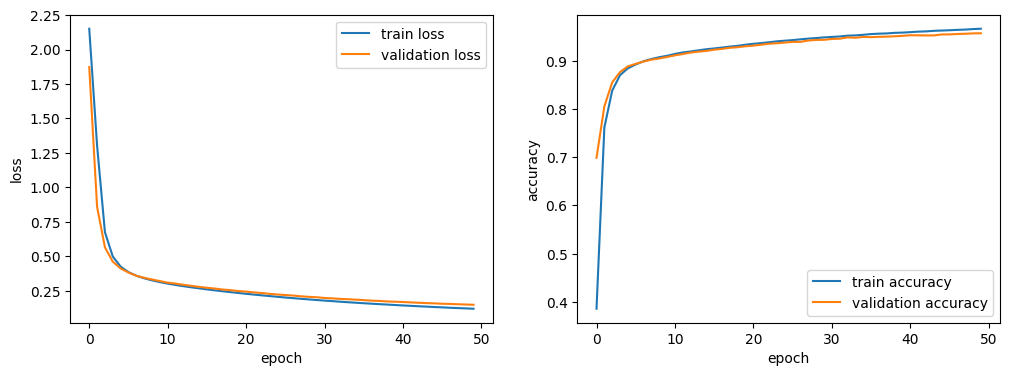

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Model 평가 - Test set 사용 

In [18]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x)
    _, y_pred = torch.max(z, 1)
    
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 95.93%


## Category 별 분류 성능 측정

accuracy of 0 = 98.47%
accuracy of 1 = 98.33%
accuracy of 2 = 96.51%
accuracy of 3 = 96.14%
accuracy of 4 = 95.82%
accuracy of 5 = 94.06%
accuracy of 6 = 96.97%
accuracy of 7 = 95.72%
accuracy of 8 = 94.46%
accuracy of 9 = 92.37%


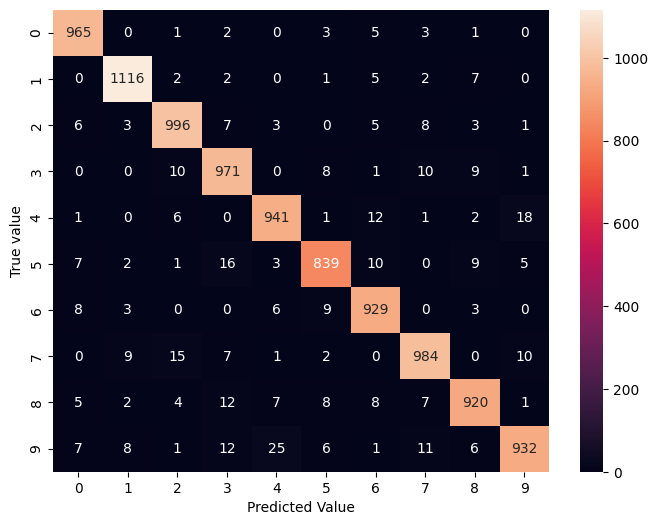

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_ylabel('True value')
ax.set_xlabel('Predicted Value')

for i in range(10):
    print(f"accuracy of {i} = {cm[i][i] / cm[i].sum() * 100:.2f}%")

## Sample Test 결과 시각화

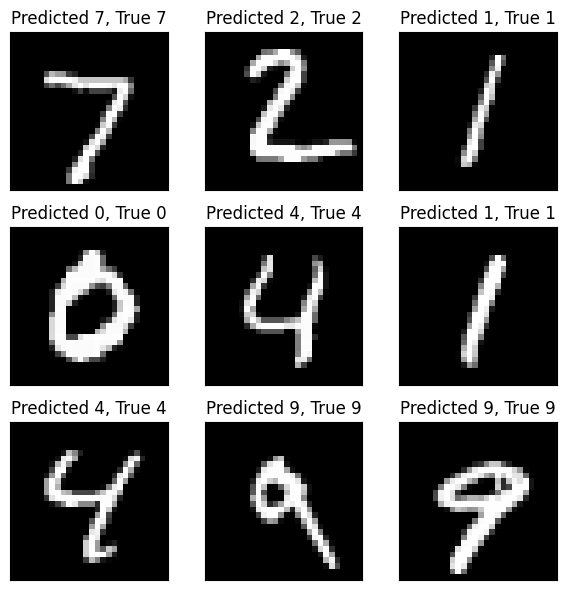

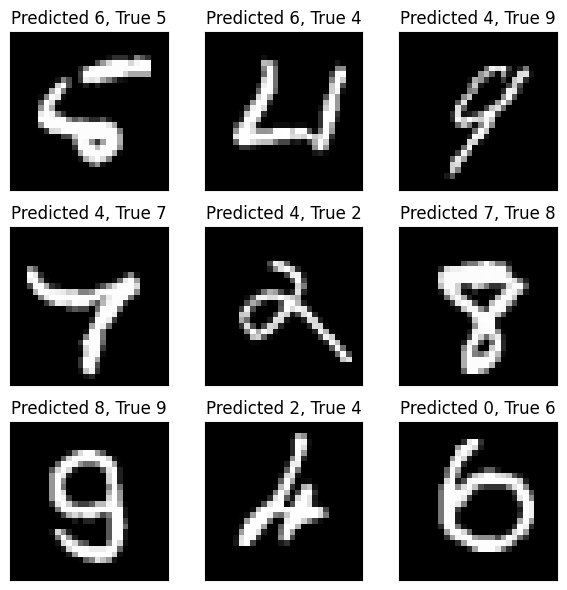

In [21]:
plt.figure(figsize=(6, 6))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(6, 6))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()